# Model Name TBD
Combines the time-distributed feature extraction of Convolutional LSTMs with the upsampling and skip connections of a U-Net to convert video-like input features and time-distributed vector metadata into a next frame semantic segmentation map.

### Import Block

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from sklearn.utils import class_weight

%matplotlib inline

### Function Definitions

In [2]:
# Loader functions
# Inspiration: https://towardsdatascience.com/writing-custom-keras-generators-fe815d992c5a

def get_2d_input(path):
    # Load array.
    t_2d_input = np.load(path)
    
    #return t_2d_input
    return t_2d_input[:,:,:,:1]

def get_1d_input(path):
    # Load array.
    t_1d_input = np.load(path)
    
    # Expand dimensions to match model input.
    t_1d_input = tf.expand_dims(tf.expand_dims(t_1d_input, 2), 2)
    
    # Put channel dim at the end.
    t_1d_input = np.moveaxis(t_1d_input, 1, -1)
    
    return t_1d_input

def get_output(path):
    # Load array.
    t_output = np.load(path)
    
    # Put channel dim at the end.
    t_output = np.moveaxis(t_output, 0, -1)
    return t_output

def data_generator(samples, num_samples, batch_size = 64, calculated_sample_weights = None):
    
    while True:
        # Suffle data at the start of each epoch.
        sample_indicies = np.arange(num_samples)
        np.random.shuffle(sample_indicies)
        n = 0
        
        while n + batch_size < num_samples:
            # Get indicies for the batch
            batch_samples  = sample_indicies[n:n + batch_size]
            n += batch_size

            batch_input_2d  = []
            batch_input_1d  = []
            batch_output = [] 
            batch_sample_weights = []

            # Read in each input, perform preprocessing and get labels
            for sample in batch_samples:
                input_2d = get_2d_input(samples.iloc[sample].features_2d)
                input_1d = get_1d_input(samples.iloc[sample].features_1d)
                output = get_output(samples.iloc[sample].labels)
                
                batch_input_2d += [input_2d]
                batch_input_1d += [input_1d]
                batch_output += [output]

                if type(calculated_sample_weights) != type(None):
                    sample_weights = calculated_sample_weights[sample]
                    batch_sample_weights += [sample_weights]
                
            # Return a tuple to feed the network
            batch_x = np.array(batch_input_2d)
            batch_v = np.array(batch_input_1d)
            batch_y = np.array(batch_output)
            
            if type(calculated_sample_weights) == type(None):
                yield(batch_x, batch_y)
            else:
                batch_sample_weights = np.array(batch_sample_weights)
                yield(batch_x, batch_y, batch_sample_weights)

In [3]:
# Solution for problem with class_weights not working with 3D outputs in tensorflow.
# From: https://github.com/keras-team/keras/issues/3653
def generate_sample_weights(training_data, class_weights): 
    #replaces values for up to 3 classes with the values from class_weights#
    sample_weights = [np.where(y==0,class_weights[0],
                        np.where(y==1,class_weights[1],
                        y)) for y in training_data]
    return np.asarray(sample_weights)

In [4]:
# SSIM/PSNR loss functions.
# Inspiration: https://stackoverflow.com/questions/57357146/use-ssim-loss-function-with-keras
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

def psnr_loss(y_true, y_pred):
    return 100 - tf.reduce_mean(tf.image.psnr(y_true, y_pred, 1.0))

In [5]:
## Dice loss functions.
## From: https://stackoverflow.com/questions/72195156/correct-implementation-of-dice-loss-in-tensorflow-keras
#def dice_coef(y_true, y_pred, smooth=100):        
#    y_true_f = tf.keras.backend.flatten(y_true)
#    y_pred_f = tf.keras.backend.flatten(y_pred)
#    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
#    dice = (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)
#    return dice
#
#def dice_coef_loss(y_true, y_pred):
#    return 1 - dice_coef(y_true, y_pred)

In [6]:
# Dice loss 
# From: https://lars76.github.io/2018/09/27/loss-functions-for-segmentation.html
def dice_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.math.sigmoid(y_pred)
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return 1 - numerator / denominator

### Model Assembly

In [7]:
# Load pre-trained fire encoder.
fire_encoder = tf.keras.models.load_model('Models/MINST_Agg_01', custom_objects = {'ssim_loss': ssim_loss, 'psnr_loss': psnr_loss})

In [8]:
# Load pre-trained VGG16
vgg = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=(32,32,3))

In [9]:
# Freeze all layers of pretrained models.
for t_layer in fire_encoder.layers:
    t_layer.trainable = False
#for t_layer in vgg.layers:
#    t_layer.trainable = False

In [10]:
# Combine fire_encoder with VGG16.
fire_encoder.add(layers.Lambda(lambda x: tf.keras.backend.repeat_elements(x=x, rep=3, axis=-1)))
for t_layer in vgg.layers[1:]:
    fire_encoder.add(t_layer)

In [11]:
# Extract weights from VGG16 model.
vgg_weights = []
for t_layer in vgg.layers:
    vgg_weights.append(t_layer.get_weights())

In [12]:
# Convert entire model to JSON and back to model so that the stranded VGG input layer is ignored.
fm_json = fire_encoder.to_json()
fire_encoder, vgg = None, None
fire_encoder = tf.keras.models.model_from_json(fm_json)

In [13]:
# Put VGG weights back.
for t_layer, t_weights in zip(fire_encoder.layers[5:], vgg_weights[1:]):
    t_layer.set_weights(t_weights)

In [29]:
combo_model.layers[7].name

'block1_conv2'

In [14]:
# Hyperparameters
upsample_filters = 512

# Apply U-Net deconvolution to fire encoder.
from_fire = layers.Conv2D(upsample_filters, (3,3), padding="same", activation='relu', name='UpConv_1_A')(fire_encoder.output)
x2 = layers.BatchNormalization()(from_fire)
x2 = layers.Conv2D(upsample_filters, (3,3), padding="same", activation='relu', name='UpConv_1_B')(x2)
x2 = layers.BatchNormalization()(x2)
x2 = layers.Conv2DTranspose(upsample_filters, (3,3), strides=(2,2), activation='relu', padding='same', name = 'UpConv_to2')(x2)
x2 = layers.BatchNormalization()(x2)
x2 = layers.concatenate([x2, fire_encoder.get_layer('block5_conv3').output])

x2 = layers.Conv2D(upsample_filters, (3,3), padding="same", activation='relu', name='UpConv_2_A')(x2)
x2 = layers.BatchNormalization()(x2)
x2 = layers.Conv2D(upsample_filters, (3,3), padding="same", activation='relu', name='UpConv_2_B')(x2)
x2 = layers.BatchNormalization()(x2)
x2 = layers.Conv2DTranspose(upsample_filters, (3,3), strides=(2,2), activation='relu', padding='same', name = 'UpConv_to4')(x2)
x2 = layers.BatchNormalization()(x2)
x2 = layers.concatenate([x2, fire_encoder.get_layer('block4_conv3').output])

x2 = layers.Conv2D(upsample_filters // 2, (3,3), padding="same", activation='relu', name='UpConv_3_A')(x2)
x2 = layers.BatchNormalization()(x2)
x2 = layers.Conv2D(upsample_filters // 2, (3,3), padding="same", activation='relu', name='UpConv_3_B')(x2)
x2 = layers.BatchNormalization()(x2)
x2 = layers.Conv2DTranspose(upsample_filters // 2, (3,3), strides=(2,2), activation='relu', padding='same', name = 'UpConv_to8')(x2)
x2 = layers.BatchNormalization()(x2)
x2 = layers.concatenate([x2, fire_encoder.get_layer('block3_conv3').output])

x2 = layers.Conv2D(upsample_filters // 4, (3,3), padding="same", activation='relu', name='UpConv_4_A')(x2)
x2 = layers.BatchNormalization()(x2)
x2 = layers.Conv2D(upsample_filters // 4, (3,3), padding="same", activation='relu', name='UpConv_4_B')(x2)
x2 = layers.BatchNormalization()(x2)
x2 = layers.Conv2DTranspose(upsample_filters // 4, (3,3), strides=(2,2), activation='relu', padding='same', name = 'UpConv_to16')(x2)
x2 = layers.BatchNormalization()(x2)
x2 = layers.concatenate([x2, fire_encoder.get_layer('block2_conv2').output])

x2 = layers.Conv2D(upsample_filters // 8, (3,3), padding="same", activation='relu', name='UpConv_5_A')(x2)
x2 = layers.BatchNormalization()(x2)
x2 = layers.Conv2D(upsample_filters // 8, (3,3), padding="same", activation='relu', name='UpConv_5_B')(x2)
x2 = layers.BatchNormalization()(x2)
x2 = layers.Conv2DTranspose(upsample_filters // 8, (3,3), strides=(2,2), activation='relu', padding='same', name = 'UpConv_to32')(x2)
x2 = layers.BatchNormalization()(x2)
x2 = layers.concatenate([x2, fire_encoder.get_layer('block1_conv2').output])

x2 = layers.Conv2D(upsample_filters // 16, (3,3), padding="same", activation='relu', name='TopConv_A')(x2)
x2 = layers.BatchNormalization()(x2)
x2 = layers.Conv2D(1, (3,3), padding="same", activation='sigmoid', name='TopConv_B')(x2)
output = layers.BatchNormalization(name = 'unet_output')(x2)

In [15]:
combo_model = tf.keras.Model(inputs = fire_encoder.input, outputs = output, name = 'combo_model')
combo_model.summary()

Model: "combo_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 fire_input (InputLayer)        [(None, 10, 32, 32,  0           []                               
                                 1)]                                                              
                                                                                                  
 fire_time_feature_1 (ConvLSTM2  (None, 10, 32, 32,   1651712    ['fire_input[0][0]']             
 D)                             128)                                                              
                                                                                                  
 fire_time_feature_2 (ConvLSTM2  (None, 10, 32, 32,   442624     ['fire_time_feature_1[0][0]']    
 D)                             64)                                                     

                                                                                                  
 batch_normalization_5 (BatchNo  (None, 4, 4, 512)   2048        ['UpConv_to4[0][0]']             
 rmalization)                                                                                     
                                                                                                  
 concatenate_1 (Concatenate)    (None, 4, 4, 1024)   0           ['batch_normalization_5[0][0]',  
                                                                  'block4_conv3[0][0]']           
                                                                                                  
 UpConv_3_A (Conv2D)            (None, 4, 4, 256)    2359552     ['concatenate_1[0][0]']          
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 4, 4, 256)   1024        ['UpConv_3_A[0][0]']             
 rmalizati

In [16]:
# Compile model.
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
#loss_fn = tf.keras.losses.BinaryCrossentropy()
#loss_fn = tf.keras.losses.MeanSquaredError()
loss_fn = dice_loss
combo_model.compile(loss=loss_fn, 
                    optimizer=opt, 
                    metrics=[tf.keras.metrics.MeanSquaredError(name='MSE'),
                             tf.keras.metrics.AUC(name='AUC'),
                             ssim_loss,
                             psnr_loss
                            ])

### Pretrain full model on moving MNIST

In [17]:
# Inspiration: https://keras.io/examples/vision/conv_lstm/

#Download and load the dataset.
fpath = tf.keras.utils.get_file(
    "moving_mnist.npy",
    "http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy",
)
dataset = np.load(fpath)

# Swap the axes representing the number of frames and number of data samples.
dataset = np.swapaxes(dataset, 0, 1)
# Now we use the entire dataset.
dataset = dataset#[1000:6000]
# Add a channel dimension since the images are grayscale.
dataset = np.expand_dims(dataset, axis=-1)

# Split into train and validation sets using indexing to optimize memory.
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]) :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]

# Normalize the data to the 0-1 range.
train_dataset = train_dataset / 255
val_dataset = val_dataset / 255

# Shift and stack frames.
i,o = [],[]
for f in range(0,10):
    i.append(train_dataset[:,f:f+10])
    o.append(train_dataset[:,f+10:f+11])
    
x_train = np.concatenate(i)
y_train = np.squeeze(np.concatenate(o), axis=1)

i,o = [],[]
for f in range(0,10):
    i.append(val_dataset[:,f:f+10])
    o.append(val_dataset[:,f+10:f+11])
    
x_val = np.concatenate(i)
y_val = np.squeeze(np.concatenate(o), axis=1)

In [18]:
#Parameters
pooler = tf.keras.layers.MaxPool2D(pool_size=(2, 2))
xt_pooled, yt_pooled, xv_pooled, yv_pooled = [],[],[],[]

# Pool training set.
for t in range(0,len(x_train),1000):
    t_x_train = x_train[t:t+1000]
    xt_pooled.append(layers.TimeDistributed(pooler, name = 'pool_to_32x32')(t_x_train).numpy())
    t_y_train = y_train[t:t+1000]
    yt_pooled.append(pooler(t_y_train).numpy())
    
# Pool validation set.
for t in range(0,len(x_val),1000):
    t_x_val = x_val[t:t+1000]
    xv_pooled.append(layers.TimeDistributed(pooler, name = 'pool_to_32x32')(t_x_val).numpy())
    t_y_val = y_val[t:t+1000]
    yv_pooled.append(pooler(t_y_val).numpy())
    
# Stack
x_train = np.concatenate(xt_pooled)
y_train = np.concatenate(yt_pooled)
x_val = np.concatenate(xv_pooled)
y_val = np.concatenate(yv_pooled)

# Shuffle each dataset in unison.
# From: https://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison
randomize = np.arange(len(x_train))
np.random.shuffle(randomize)
x_train = x_train[randomize]
y_train = y_train[randomize]

randomize = np.arange(len(x_val))
np.random.shuffle(randomize)
x_val = x_val[randomize]
y_val = y_val[randomize]

In [19]:
# Throw out variables that will no longer be used to recover memory.
train_dataset, val_dataset,train_index, val_index = None, None, None, None
t_x_train, t_y_train, t_x_val, t_y_val = None, None, None, None
xt_pooled, yt_pooled, xv_pooled, yv_pooled = None, None, None, None
pooler, i, o, dataset = None, None, None, None

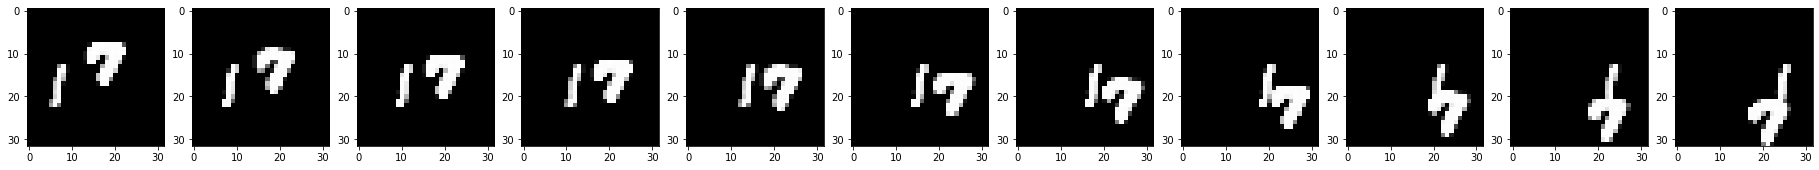

In [20]:
# Visualize the dataset to make sure the shifting and shuffling operations worked properly.
sample_idx = np.random.randint(0, len(x_train))
fig, axes = plt.subplots(1, 11, figsize=(32, 8))

# Plot the fire frames.
for idx, ax in enumerate(axes):
    if idx == 10:
        ax.imshow(np.squeeze(y_train[sample_idx]), cmap="gray")
    else:
        ax.imshow(np.squeeze(x_train[sample_idx][idx]), cmap="gray")

In [21]:
# Build a simple generator
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

batch_size = 32
train_gen = DataGenerator(x_train, y_train, batch_size)
val_gen = DataGenerator(x_val, y_val, batch_size)

In [22]:
# Define some callbacks to improve training.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights = True, verbose = 1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, verbose = 1)

combo_model.fit(train_gen,
                   epochs = 10, 
                   verbose = 1, 
                   batch_size = batch_size,
                   validation_data = val_gen,
                   callbacks = [early_stopping, reduce_lr],
                  )

Epoch 1/10
1266/2813 [============>.................] - ETA: 4:33 - loss: 0.7782 - MSE: 3.0744 - AUC: 0.7446 - ssim_loss: 0.9913 - psnr_loss: 104.3012

KeyboardInterrupt: 

In [22]:
combo_model.save('Models/Combo_Rough_001')

INFO:tensorflow:Assets written to: Models/Combo_Rough_001\assets


INFO:tensorflow:Assets written to: Models/Combo_Rough_001\assets


### Visualize Results

In [23]:
t_preds = combo_model.predict(x_val)

313/313 [==============================] - 46s 145ms/step


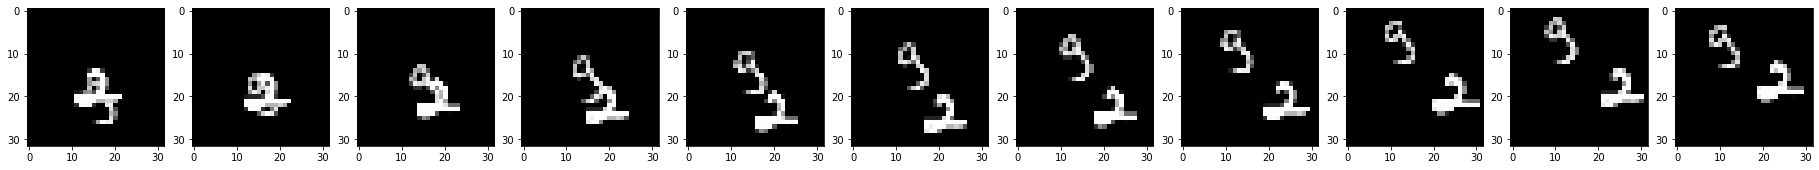

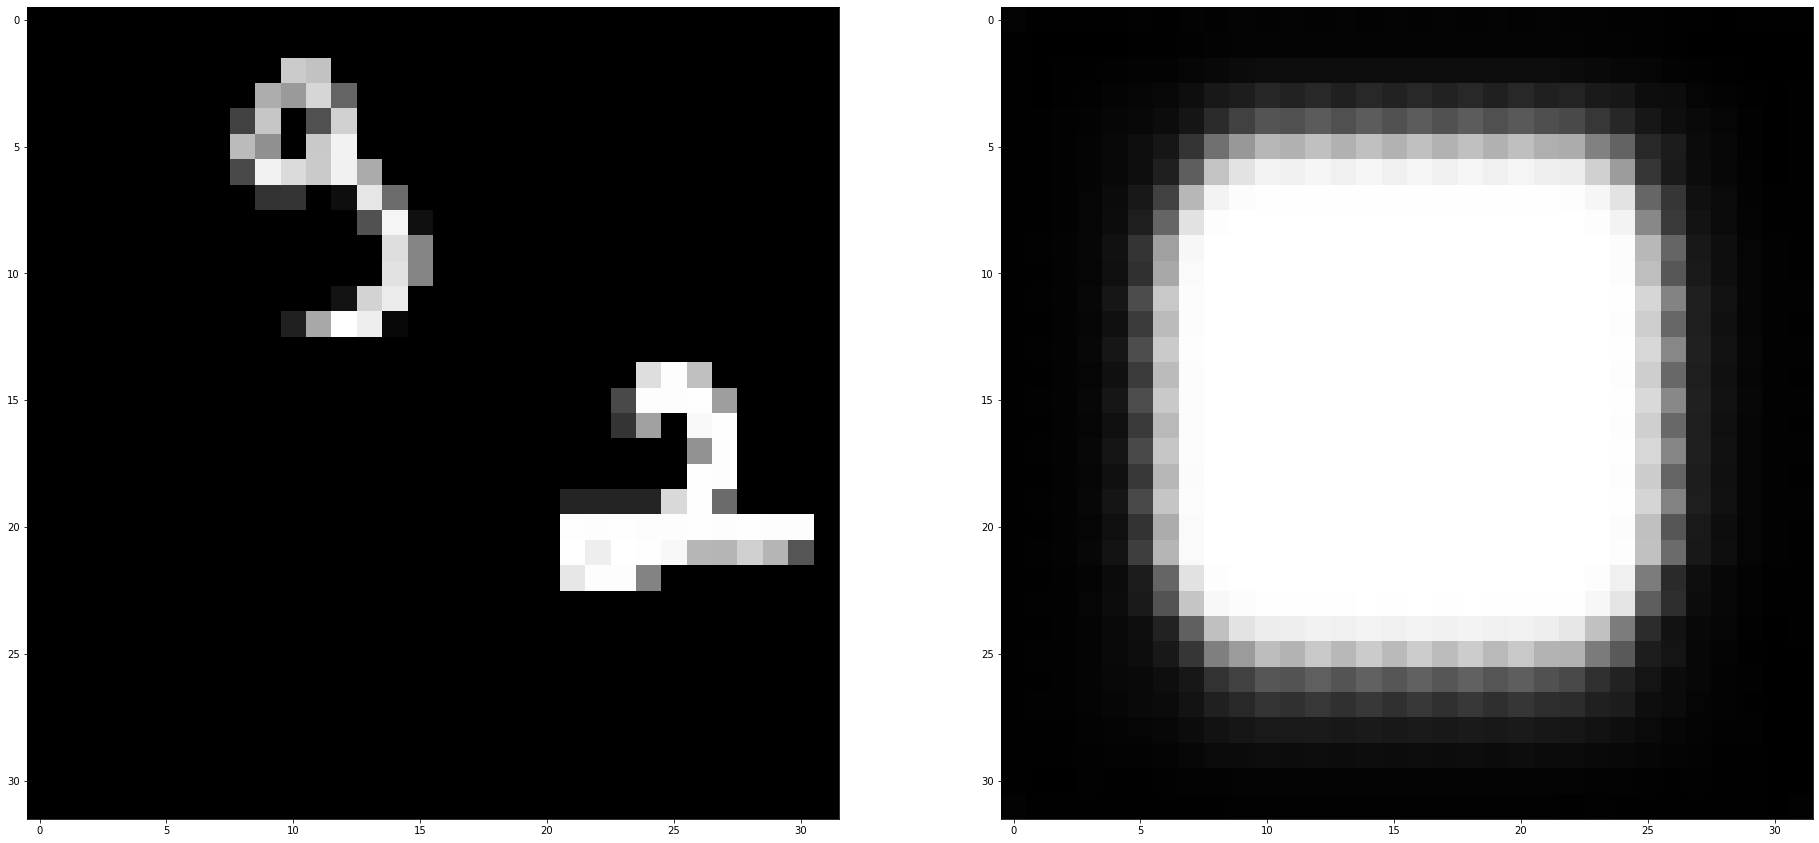

In [27]:
sample_idx = np.random.randint(0, len(x_val))

# Construct a figure for the original and new frames.
fig, axes = plt.subplots(1, 11, figsize=(32, 8))

# Plot the fire frames.
for idx, ax in enumerate(axes):
    if idx == 10:
        ax.imshow(np.squeeze(y_val[sample_idx]), cmap="gray")
    else:
        ax.imshow(np.squeeze(x_val[sample_idx][idx]), cmap="gray")
    #ax.set_title(f"F Frame {idx + 1}")
    #ax.axis("off")

fig, axes = plt.subplots(1, 2, figsize=(32, 16))
axes[0].imshow(np.squeeze(x_val[sample_idx][9]), cmap="gray")
axes[1].imshow(np.squeeze(t_preds[sample_idx]), cmap="gray")

In [25]:
# Compute and show set scores.
set_ssim = tf.image.ssim(tf.cast(y_val, dtype='float32'), t_preds, 1.0)
set_psnr = tf.image.psnr(tf.cast(y_val, dtype='float32'), t_preds, 1.0)
set_mse = tf.keras.metrics.mean_squared_error(y_val, t_preds)
print('Model Prediction Report')
print('SSIM:', np.mean(set_ssim))
print('PSNR:', np.mean(set_psnr) / 100)
print('MSE:', np.mean(set_mse))

Model Prediction Report
SSIM: 0.0068119196
PSNR: -0.07871980667114258
MSE: 6.127059
